In [68]:
# !pip install nameparser
# !pip install lightgbm
# !pip install catboost
# !pip install dabl

# Housing Prices Prediction

## Summary
Just wanted to perform a quick analysis using Tree-Based Models to make a prediction on the Titanic dataset.  Many have done and contributed their exploratory data analyses in Kaggle.  Based on these analyses, the focus here is to perform some quick data transformation and feature engineering, follow by model training and prediction.  Finally, generating the submission csv for assessment in Kaggle.

I aim for this notebook to be short and not dwell in too much details on why certain parameters or models are selected.  Purpose is for tree-based models to perform well in making predictions on unseen data.

----
## References

1. https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python
2. https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard
3. https://www.kaggle.com/lavanyashukla01/how-i-made-top-0-3-on-a-kaggle-competition


---
## Importing Libraries

In [69]:
import time

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# %matplotlib inline

import re

import warnings
warnings.filterwarnings('ignore')

## Changing the default settings
pd.options.display.max_columns = 50
plt.rcParams.update({'figure.figsize':(15,6), 'figure.dpi':60})
plt.style.use('fivethirtyeight')
# plt.style.use('ggplot')

import os
for dirname, _, filenames in os.walk('../data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../data/test.csv
../data/data_description.txt
../data/train.csv
../data/results.csv
../data/sample_submission.csv


---
## Helper Functions

1. **combineTrainTest** - For data transformation and feature engineering with needs to be applied to both Train and Test set consistently.
2. **splitTrainTest** - For splitting the combined dataset back to train and test after data transformation and feature engineering.
3. **plot_importances** - For showing the feature importances as determined by the model.

In [70]:
def combineTrainTest(train, test, features):
    train = train[features]
    test = test[features]
    out = pd.concat([train, test])
    return out

def splitTrainTest(traintest, train, test, target):
    train = traintest.loc[train.index].join(train[target])
    test = traintest.loc[test.index]
    return train, test

def plot_importances(model, columns, top=20):
    importances = pd.Series(data=model.feature_importances_, index=columns).sort_values()

    plt.figure(figsize=(10,6))
    importances[-top:].sort_values().plot(kind='barh', color='lightgreen')
    plt.title('Features Importances')
    plt.show()
    
def plot_scatter(data, xlabel, ylabel):
    fig, ax = plt.subplots()
    ax.scatter(x = data[xlabel], y = data[ylabel])
    plt.xlabel(xlabel, fontsize=13)
    plt.ylabel(ylabel, fontsize=13)
    plt.show()    
    
def plot_pairs(data, columns):
    #scatterplot
    sns.set()
    sns.pairplot(data[columns], size = 2.5)
    plt.show()


def plot_check(data, xlabel, ylabel):
    fig, ax = plt.subplots()
    ax.scatter(x = data[xlabel], y = data[ylabel])
    plt.xlabel(xlabel, fontsize=13)
    plt.ylabel(ylabel, fontsize=13)
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.show()    


---
## Loading the Dataset

Some quick information

In [71]:
DATA_FOLDER = '../data/'
train = pd.read_csv(DATA_FOLDER + 'train.csv', index_col='Id')
test = pd.read_csv(DATA_FOLDER + 'test.csv', index_col='Id')
submission = pd.read_csv(DATA_FOLDER + 'sample_submission.csv')

In [72]:
print(train.shape)
print(test.shape)

(1460, 80)
(1459, 79)


In [73]:
DATA_FOLDER = '../data/'
train = pd.read_csv(DATA_FOLDER + 'train.csv', index_col='Id')
test = pd.read_csv(DATA_FOLDER + 'test.csv', index_col='Id')
submission = pd.read_csv(DATA_FOLDER + 'sample_submission.csv')

target = [col for col in train.columns if col not in test.columns]
features = [col for col in train.columns if col in test.columns]

num_features = test._get_numeric_data().columns.tolist()
cat_features = [col for col in test.columns if col not in num_features + target]

print('Target: {}\n'.format(target))
print('List of features: {}\n'.format(features))
print('List of numeric features: {}\n'.format(num_features))
print('List of categorical features: {}\n'.format(cat_features))

Target: ['SalePrice']

List of features: ['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 

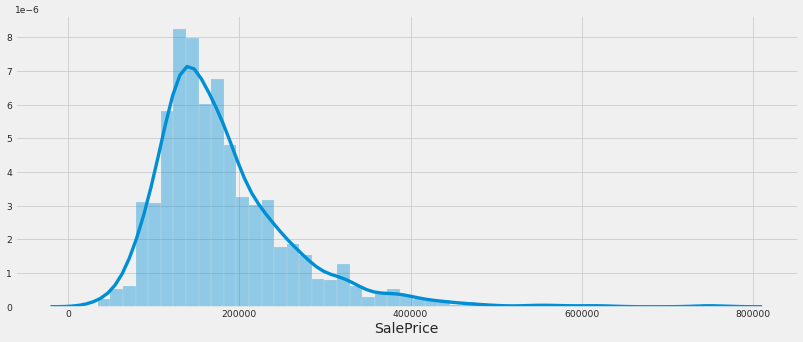

In [74]:
import seaborn as sns
sns.distplot(train['SalePrice'])

Target looks like regression
Showing only top 10 of 22 continuous features
Showing only top 10 of 45 categorical features


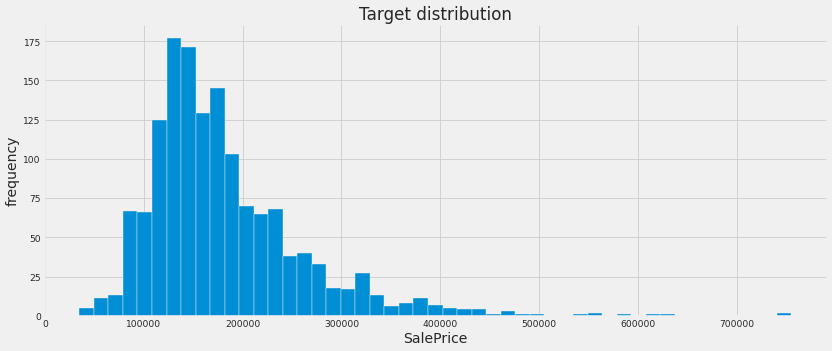

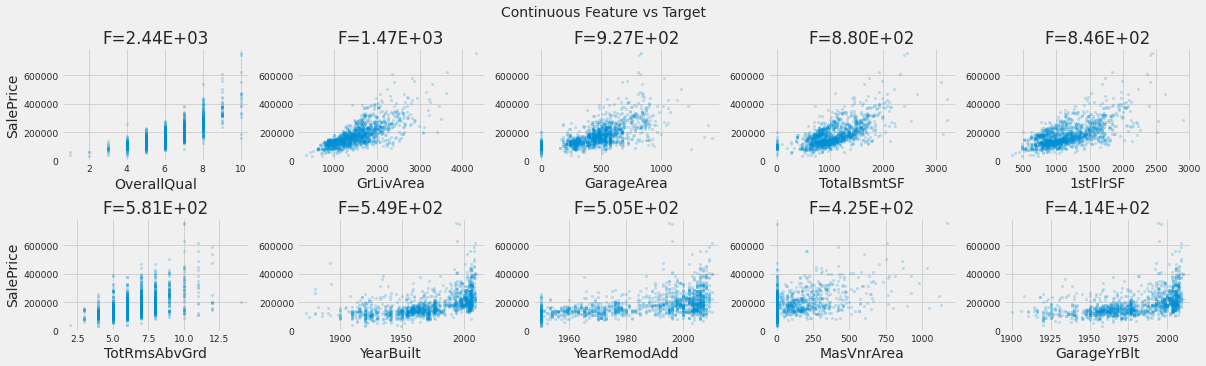

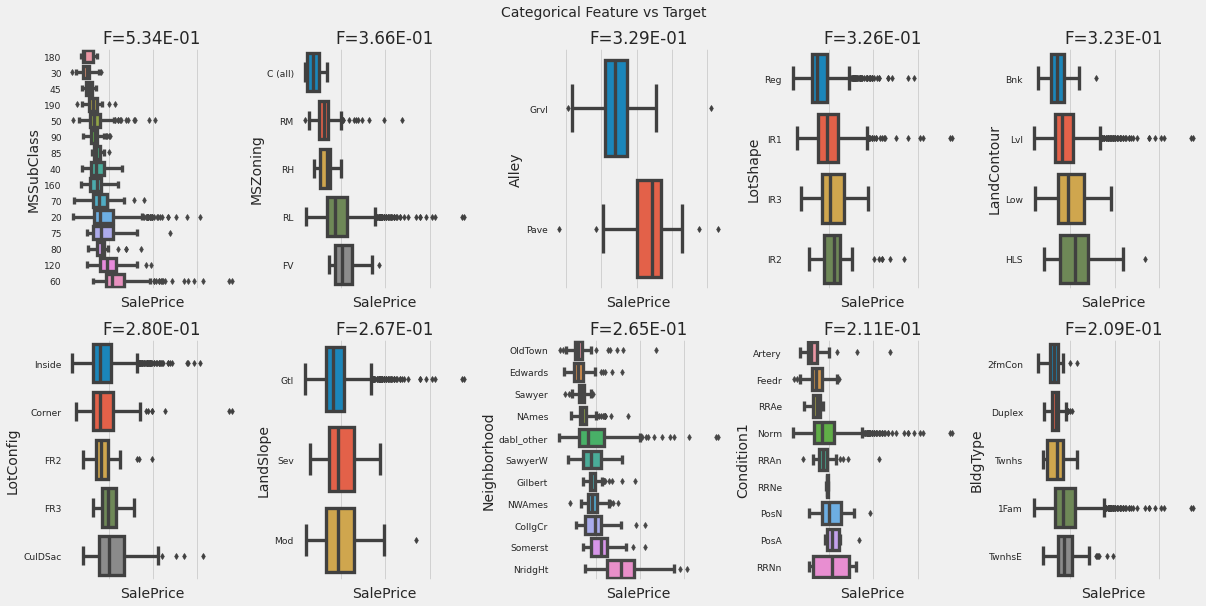

In [75]:
import dabl
dabl.plot(train, target_col = 'SalePrice')

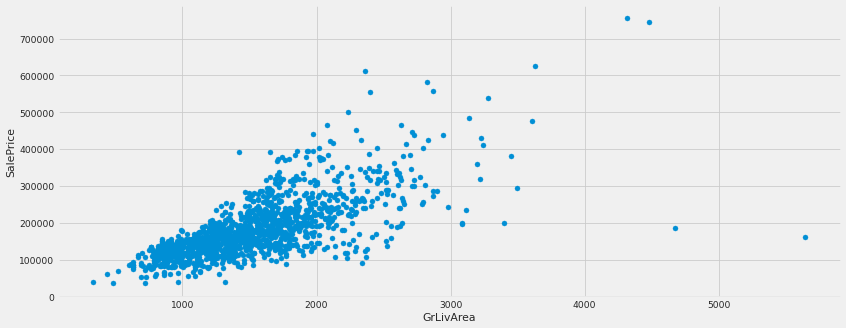

In [76]:
plot_scatter(train, 'GrLivArea', 'SalePrice')

In [77]:
## Delete outliers
train = train.drop(train[(train.GrLivArea > 4000) & (train.SalePrice < 300000)].index)

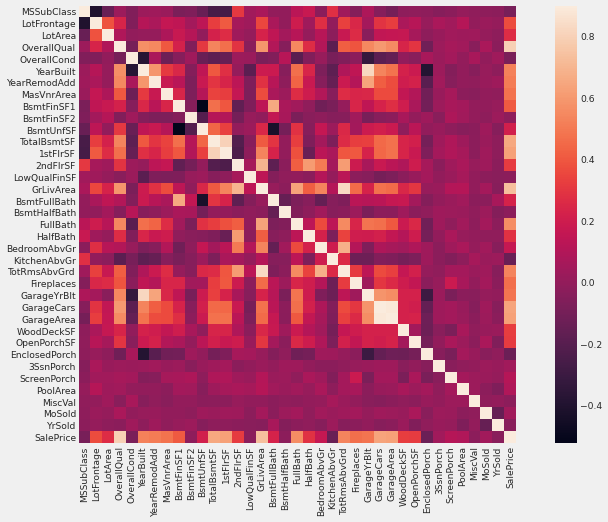

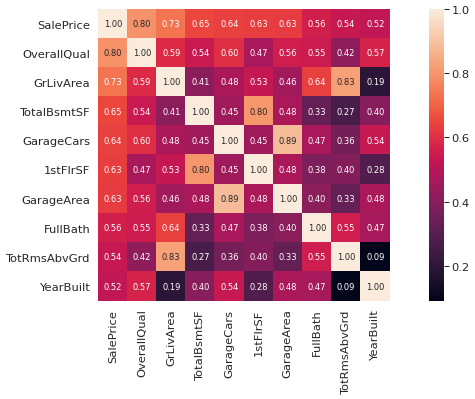

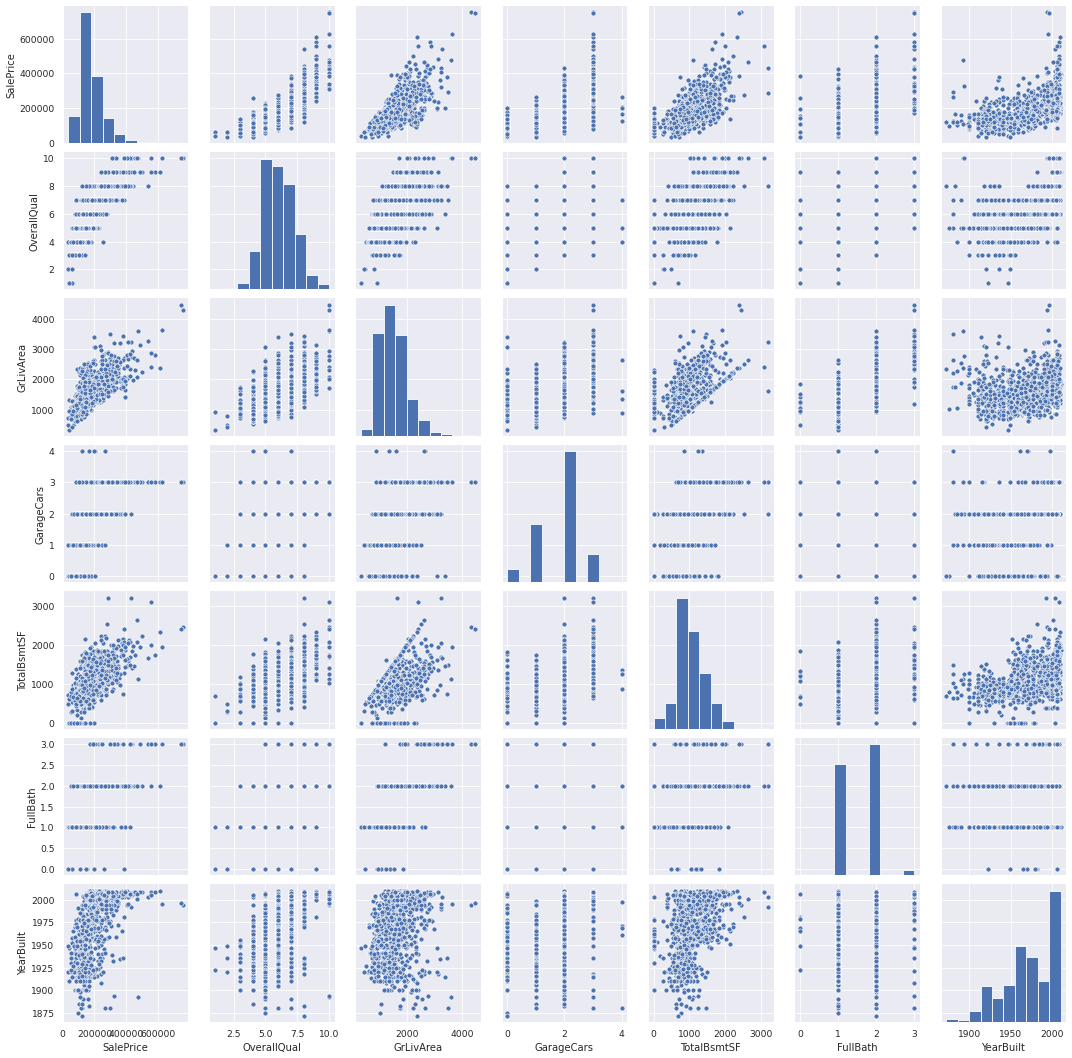

In [78]:
#correlation matrix
corrmat = train.corr()
f, ax = plt.subplots(figsize=(15, 9))
sns.heatmap(corrmat, vmax=.9, square=True)
plt.show()

#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, 
                 yticklabels=cols.values, xticklabels=cols.values)
plt.show()

cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
plot_pairs(train, cols)

In [79]:
na_cols = train.columns[train.isna().any()].tolist()
train[na_cols].isnull().sum().sort_values(ascending=False)

PoolQC          1452
MiscFeature     1404
Alley           1367
Fence           1177
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64

In [80]:
# train.isnull().sum(axis=1).sort_values(ascending=False)

In [81]:
print(train[num_features].shape)
print(train[cat_features].shape)
print(test[num_features].shape)
print(test[cat_features].shape)

(1458, 36)
(1458, 43)
(1459, 36)
(1459, 43)


In [82]:
train[cat_features].describe()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1458,1458,91,1458,1458,1458,1458,1458,1458,1458,1458,1458,1458,1458,1458,1458,1458,1450,1458,1458,1458,1421,1421,1420,1421,1420,1458,1458,1458,1457,1458,1458,768,1377,1377,1377,1377,1458,6,281,54,1458,1458
unique,5,2,2,4,4,2,5,3,25,9,8,5,8,6,7,15,16,4,4,5,6,4,4,4,6,6,6,5,2,5,4,7,5,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,Fa,MnPrv,Shed,WD,Normal
freq,1149,1452,50,925,1311,1457,1051,1380,225,1260,1444,1218,726,1141,1433,515,504,864,906,1280,645,649,1309,953,430,1254,1426,739,1363,1332,735,1358,378,869,605,1309,1324,1338,2,157,49,1267,1198


---
## Data Analysis and Feature Engineering

Combining the train and test set together so that data transformation will be consistent and applied to both datasets.

In [83]:
traintest = combineTrainTest(train, test, features)
traintest.MSSubClass = traintest.MSSubClass.astype('category')
traintest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2917 entries, 1 to 2919
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   MSSubClass     2917 non-null   category
 1   MSZoning       2913 non-null   object  
 2   LotFrontage    2431 non-null   float64 
 3   LotArea        2917 non-null   int64   
 4   Street         2917 non-null   object  
 5   Alley          198 non-null    object  
 6   LotShape       2917 non-null   object  
 7   LandContour    2917 non-null   object  
 8   Utilities      2915 non-null   object  
 9   LotConfig      2917 non-null   object  
 10  LandSlope      2917 non-null   object  
 11  Neighborhood   2917 non-null   object  
 12  Condition1     2917 non-null   object  
 13  Condition2     2917 non-null   object  
 14  BldgType       2917 non-null   object  
 15  HouseStyle     2917 non-null   object  
 16  OverallQual    2917 non-null   int64   
 17  OverallCond    2917 non-null   in

Check columns with null values

In [84]:
na_cols = traintest.columns[traintest.isna().any()].tolist()
traintest[na_cols].isnull().sum().sort_values(ascending=False)

PoolQC          2908
MiscFeature     2812
Alley           2719
Fence           2346
FireplaceQu     1420
LotFrontage      486
GarageFinish     159
GarageYrBlt      159
GarageQual       159
GarageCond       159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Utilities          2
Functional         2
Exterior2nd        1
Exterior1st        1
SaleType           1
BsmtFinSF1         1
BsmtFinSF2         1
BsmtUnfSF          1
Electrical         1
KitchenQual        1
GarageCars         1
GarageArea         1
TotalBsmtSF        1
dtype: int64

### PoolQC

In [85]:
traintest.loc[(traintest.PoolQC.isnull()) & (traintest.PoolArea == 0), 'PoolQC'] = 'NA'
traintest['PoolQC'] = traintest.groupby(['OverallQual'])['PoolQC'].transform(lambda x: x.fillna(x.mode()[0]))

### FireplaceQu

In [86]:
traintest.loc[(traintest.FireplaceQu.isnull()) & (traintest.Fireplaces == 0), 'FireplaceQu'] = 'NA'
traintest['FireplaceQu'] = traintest.groupby(['OverallQual'])['FireplaceQu'].transform(lambda x: x.fillna(x.mode()[0]))

### MiscFeature

In [87]:
traintest.loc[(traintest.MiscFeature.isnull()), 'MiscFeature'] = 'NA'
traintest.loc[(traintest.Fence.isnull()), 'Fence'] = 'NA'
traintest.loc[(traintest.Alley.isnull()), 'Alley'] = 'NA'

### Lot Info

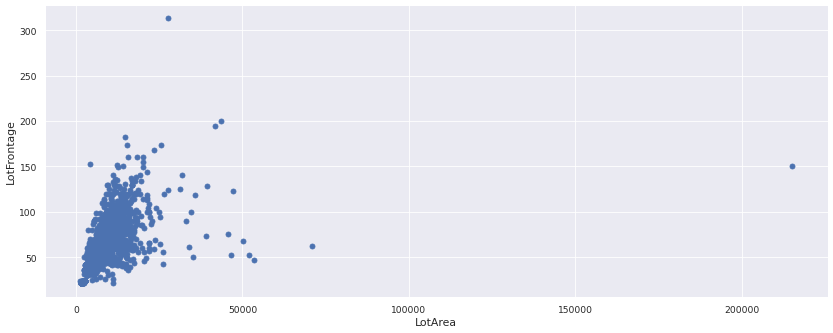

In [88]:
traintest.filter(regex='Lot').head()
plot_scatter(traintest, 'LotArea', 'LotFrontage')

In [89]:
from scipy.stats.mstats import winsorize

# Check minimum sum of donations
# print(traintest["LotArea"].min())
# print(traintest["LotArea"].max())

traintest["LotArea"] = winsorize(traintest["LotArea"], limits=[0, 0.005])

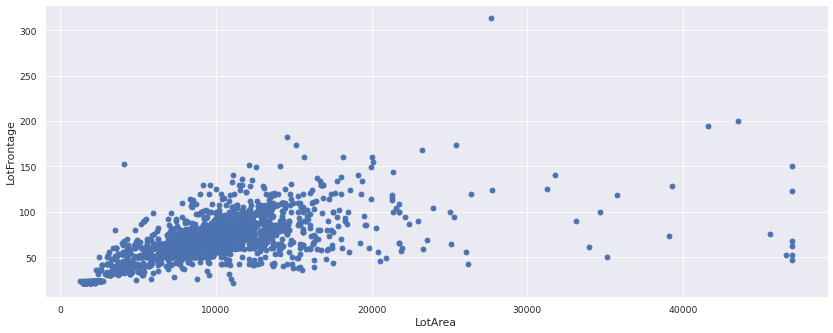

In [90]:
traintest[(traintest.LotArea > 50000)].filter(regex='Lot').head()
plot_scatter(traintest, 'LotArea', 'LotFrontage')

In [91]:
traintest['LotAreaGroup'] = pd.qcut(traintest['LotArea'], 5, 
                                    labels=['XS','S','M','L','XL'])

traintest['LotFrontage'] = traintest.groupby(['LotAreaGroup','LotShape'])['LotFrontage'].transform(lambda x: x.fillna(x.median()))
traintest['LotFrontage'] = traintest.groupby(['LotAreaGroup'])['LotFrontage'].transform(lambda x: x.fillna(x.median()))

### Garage Info

In [92]:
traintest.loc[(traintest.GarageYrBlt.isnull()), 'GarageYrBlt'] = -1
traintest.loc[(traintest.GarageFinish.isnull()), 'GarageFinish'] = 'NA'
traintest.loc[(traintest.GarageQual.isnull()), 'GarageQual'] = 'NA'
traintest.loc[(traintest.GarageCond.isnull()), 'GarageCond'] = 'NA'
traintest.loc[(traintest.GarageType.isnull()), 'GarageType'] = 'NA'

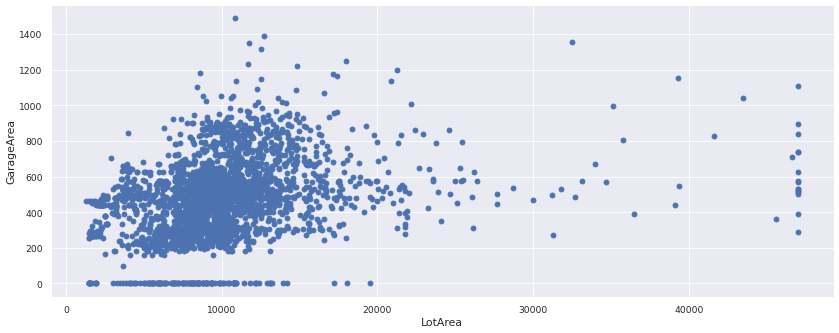

In [93]:
plot_scatter(traintest, 'LotArea', 'GarageArea')

In [94]:
traintest['GarageArea'] = traintest.groupby(['LotAreaGroup'])['GarageArea'].transform(lambda x: x.fillna(x.median()))
traintest['GarageCars'] = traintest.groupby(['LotAreaGroup'])['GarageCars'].transform(lambda x: x.fillna(x.median()))

### Basement Info

In [95]:
traintest.loc[(traintest.BsmtCond.isnull()), 'BsmtCond'] = 'NA'
traintest.loc[(traintest.BsmtExposure.isnull()), 'BsmtExposure'] = 'NA'
traintest.loc[(traintest.BsmtQual.isnull()), 'BsmtQual'] = 'NA'
traintest.loc[(traintest.BsmtFinType1.isnull()), 'BsmtFinType1'] = 'NA'
traintest.loc[(traintest.BsmtFinType2.isnull()), 'BsmtFinType2'] = 'NA'

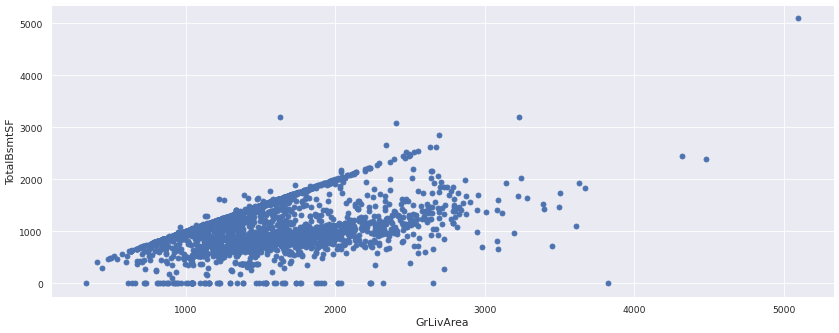

In [96]:
plot_scatter(traintest, 'GrLivArea', 'TotalBsmtSF')

In [97]:
traintest['GrLivAreaGroup'] = pd.qcut(traintest['GrLivArea'], 5, 
                                    labels=['XS','S','M','L','XL'])
traintest['TotalBsmtSF'] = traintest.groupby(['GrLivAreaGroup'])['TotalBsmtSF'].transform(lambda x: x.fillna(x.median()))

In [98]:
traintest['TotalBsmtSFGroup'] = pd.qcut(traintest['TotalBsmtSF'], 5, 
                                    labels=['XS','S','M','L','XL'])

traintest['BsmtFullBath'] = traintest.groupby(['TotalBsmtSFGroup'])['BsmtFullBath'].transform(lambda x: x.fillna(x.median()))
traintest['BsmtHalfBath'] = traintest.groupby(['TotalBsmtSFGroup'])['BsmtHalfBath'].transform(lambda x: x.fillna(x.median()))


In [99]:
traintest[traintest.BsmtFinSF1.isnull()].filter(regex='Bsmt')

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath,TotalBsmtSFGroup
Id,,,,,,,,,,,,
2121,NA,NA,NA,NA,NaN,NA,NaN,NaN,864.0,0.0,0.0,S


This record belongs to the test data set.  Hence cannot be dropped.  To drop the columns instead.

In [100]:
# traintest.loc[traintest.BsmtFinSF1.isnull(), ['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF']]
traintest = traintest.drop(['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF'], axis=1)

In [101]:
# garage = traintest.columns[traintest.columns.str.startswith('Garage')].tolist()
# basement = traintest.columns[traintest.columns.str.contains('Bsmt')].tolist()
# quality = traintest.columns[traintest.columns.str.contains('Qual')].tolist()

In [102]:
na_cols = traintest.columns[traintest.isna().any()].tolist()
traintest[na_cols].isnull().sum().sort_values(ascending=False)

MasVnrType     24
MasVnrArea     23
MSZoning        4
Functional      2
Utilities       2
SaleType        1
KitchenQual     1
Electrical      1
Exterior2nd     1
Exterior1st     1
dtype: int64

### MasVnrType Info

In [103]:
traintest.loc[(traintest.MasVnrType.isnull()) & (traintest.MasVnrArea.isnull()), 'MasVnrType'] = 'None'
traintest.loc[(traintest.MasVnrType == 'None') & (traintest.MasVnrArea.isnull()), 'MasVnrArea'] = 0
traintest['MasVnrType'] = traintest.groupby(['MSSubClass'])['MasVnrType'].transform(lambda x: x.fillna(x.mode()[0]))

### Utilities Info

In [104]:
# traintest['Utilities'] = traintest.groupby(['MSSubClass','YearRemodAdd'])['Utilities'].transform(lambda x: x.fillna(x.mode()[0]))
train.Utilities.value_counts()
traintest = traintest.drop(['Utilities'], axis=1)

### Miscellaneous Info

In [105]:
traintest['MSZoning'] = traintest.groupby(['MSSubClass','Neighborhood'])['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
traintest['Functional'] = traintest.groupby(['OverallQual'])['Functional'].transform(lambda x: x.fillna(x.mode()[0]))
traintest['KitchenQual'] = traintest.groupby('OverallQual')['KitchenQual'].transform(lambda x: x.fillna(x.mode()[0]))
traintest['Electrical'] = traintest.groupby(['MSSubClass','YearRemodAdd'])['Electrical'].transform(lambda x: x.fillna(x.mode()[0]))
traintest['SaleType'] = traintest['SaleType'].fillna(traintest['SaleType'].mode()[0])


### Columns to add

In [106]:
traintest['TotalSF'] = traintest['1stFlrSF'] + traintest['2ndFlrSF'] + traintest['TotalBsmtSF']

### Columns to drop

In [107]:
# traintest['Exterior1st'] = traintest.groupby('ExterQual')['Exterior1st'].transform(lambda x: x.fillna(x.mode()[0]))
# traintest['Exterior2nd'] = traintest.groupby('ExterQual')['Exterior2nd'].transform(lambda x: x.fillna(x.mode()[0]))

In [108]:
todrop = ['Neighborhood','Exterior1st','Exterior2nd']
traintest = traintest.drop(todrop, axis=1)

In [109]:
# traintest.groupby('OverallQual')['KitchenQual'].agg(pd.Series.mode)

### Final Check

In [110]:
traintest.isnull().any().any()

False

In [111]:
traintest.describe(include=np.number)

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,TotalSF
count,2917.00000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000
mean,69.73843,9954.323620,6.086390,5.564964,1971.287967,1984.248200,100.931436,1049.263970,1157.692492,335.861502,4.697635,1498.251628,0.428865,0.061364,1.567364,0.379842,2.860130,1.044566,6.448063,0.596160,1870.215632,1.766198,472.409325,93.629414,47.280082,23.114158,2.604045,16.073363,2.088790,50.860816,6.213576,2007.792938,2542.817964
std,21.54500,5157.292522,1.406704,1.113414,30.286991,20.892257,178.032499,429.046043,385.264298,428.119663,46.412570,496.908626,0.523943,0.245687,0.552465,0.502782,0.822967,0.214532,1.564281,0.644773,450.052870,0.761412,214.584074,126.532643,67.118965,64.263424,25.196714,56.202054,34.561371,567.595198,2.713070,1.315328,780.610936
min,21.00000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,334.000000
25%,60.00000,7476.000000,5.000000,5.000000,1953.000000,1965.000000,0.000000,793.000000,876.000000,0.000000,0.000000,1126.000000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1957.000000,1.000000,320.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,2000.000000
50%,70.00000,9452.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,988.000000,1082.000000,0.000000,0.000000,1444.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1977.000000,2.000000,480.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,2448.000000
75%,82.00000,11556.000000,7.000000,6.000000,2001.000000,2004.000000,163.000000,1302.000000,1384.000000,704.000000,0.000000,1743.000000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2001.000000,2.000000,576.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,2990.000000
max,313.00000,47007.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5095.000000,5095.000000,2065.000000,1064.000000,5095.000000,3.000000,2.000000,4.000000,2.000000,8.000000,3.000000,15.000000,4.000000,2207.000000,5.000000,1488.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000,10190.000000


In [112]:
traintest.describe(include=[np.object])

,MSZoning,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,2917,2917,2917,2917,2917,2917,2917,2917,2917,2917,2917,2917,2917,2917,2917,2917,2917,2917,2917,2917,2917,2917,2917,2917,2917,2917,2917,2917,2917,2917,2917,2917,2917,2917,2917,2917,2917,2917,2917
unique,5,2,3,4,4,5,3,9,8,5,8,6,7,4,4,5,6,5,5,5,7,7,6,5,2,5,4,7,6,7,4,6,6,3,4,5,5,9,6
top,RL,Pave,NA,Reg,Lvl,Inside,Gtl,Norm,Norm,1Fam,1Story,Gable,CompShg,None,TA,TA,PConc,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,NA,Attchd,Unf,TA,TA,Y,NA,NA,NA,WD,Normal
freq,2264,2905,2719,1859,2622,2132,2776,2511,2888,2423,1471,2310,2875,1766,1798,2536,1306,1283,2604,1904,851,2491,2872,1491,2721,2670,1493,2716,1420,1722,1230,2602,2652,2639,2908,2346,2812,2526,2402


In [113]:
num_features = traintest._get_numeric_data().columns.tolist()
cat_features = [col for col in traintest.columns if col not in num_features + target]

def procDummies(data, features):
    for feature in features:
        data = data.join(pd.get_dummies(data[feature], drop_first=True, prefix=feature)).drop(feature, axis=1)
    return data

def procNormalise(data, features):
    for feature in features:
        data[feature] = np.log1p(data[feature])
    return data

### One-Hot Encoding

In [114]:
# traintest1 = procDummies(traintest, cat_features)
traintest = pd.get_dummies(traintest, drop_first=True)

### Normalise Numerical Columns

In [115]:
# impt_features = ['GrLivArea', 'TotalBsmtSF', 'OverallQual', 'YearBuilt']
# traintest = traintest[impt_features]
tonormalise = ['LotFrontage', 'LotArea','MasVnrArea','TotalBsmtSF',
               '1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea',
               'GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch',
               '3SsnPorch','ScreenPorch','PoolArea','MiscVal','TotalSF']

# plot_pairs(traintest, tonormalise)

In [116]:
traintest = procNormalise(traintest, tonormalise)

In [117]:
# plot_pairs(traintest, tonormalise)

In [118]:
Xy, X_test = splitTrainTest(traintest, train, test, target)

X = Xy.drop(target, axis=1)
y = Xy[target]

print(X.shape)
print(y.shape)
print(X_test.shape)

(1458, 228)
(1458, 1)
(1459, 228)


In [119]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1458 entries, 1 to 1460
Columns: 228 entries, LotFrontage to TotalBsmtSFGroup_XL
dtypes: float64(21), int64(12), uint8(195)
memory usage: 704.9 KB


In [120]:
y = procNormalise(y, ['SalePrice'])

## Tree-Based Model Training

Focus on the following models:
1. Adaptive Boosting (Adaboost)
2. Support Vector Machine (SVM)
3. CatBoost
4. LightGBM
5. Random Forest
6. Histogram-Based Gradient Boosting
6. Gradient Boosting Machine
7. XGBoost
8. Voting Classifier

In [121]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, ShuffleSplit, cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor

# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import AdaBoostClassifier
# from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV

SEED = 3567

## Test

In [122]:
model = LGBMRegressor()
# model = XGBRegressor(objective='reg:squarederror')
# model = GradientBoostingRegressor()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
print('RMSE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

RMSE: -0.129 (0.013)


In [123]:
model.fit(X, y)
np.expm1(model.predict(X_test))

array([117090.26588365, 158783.09329308, 185355.2662346 , ...,
       169301.61472964, 111708.60940214, 218291.5401112 ])

Preparing parameters for hyperparameters tuning using GridSearchCV

In [124]:
models = [
#     ('ada', AdaBoostClassifier()),
#     ('svc', SVC(probability=True)),    
#     ('cat', CatBoostRegressor(verbose=0)),
#     ('hgb', HistGradientBoostingRegressor()),
#     ('rf', RandomForestRegressor()),
    ('lgbm', LGBMRegressor()),
    ('gb', GradientBoostingRegressor()),
    ('xgb', XGBRegressor(objective='reg:squarederror'))
]

n_estimators = [300]
max_features = list(np.arange(0.6,1.1,0.2))
max_depth = list(np.arange(-1,12,2))
learning_rate = [0.01, 0.05, .1]
gamma = list(np.arange(0.01,0.06,0.02))
subsample = list(np.arange(0.6,1.1,0.2))

# n_estimators = list(np.arange(150,220,30))
# max_features = list(np.arange(0.5,1.0,0.2))
# max_depth = list(np.arange(7,12,2))
# colsample_bytree = list(np.arange(0.3,0.6,0.2))
# lambda_l2 = list(np.arange(0.6,1.0,0.3))
# alpha_l1 = list(np.arange(0.01,0.1,0.04))

grid_param = [
#     [{ ## ada
#         'n_estimators': n_estimators,
#         'learning_rate': learning_rate,
#         'random_state': [SEED]
#     }],
#     [{ ## svc
#         'C': [1,2,3,4,5],
#         'gamma': gamma,
#         'decision_function_shape': ['ovo', 'ovr'],
#         'probability': [True],
#         'random_state': [SEED] 
#     }],    
#     [{ ## cat
#         'learning_rate': learning_rate,
#         'max_depth': max_depth,
#         'n_estimators': n_estimators,
#         'subsample': subsample,
#         'random_state': [SEED]  
#     }],
#     [{ ## hgb
#         'learning_rate': learning_rate,
#         'max_depth': max_depth,
#         'random_state': [SEED]
#     }],
#     [{ ## rf
#         'n_estimators': n_estimators,
#         'max_features': max_features,
#         'max_depth': max_depth,
#         'max_samples': subsample,
#         'criterion': ['mse', 'mae'],
#         'oob_score': [True],
#         'random_state': [SEED]
#     }],
    [{ ## lgbm
        'learning_rate': learning_rate,
        'max_depth': max_depth,
        'n_estimators': n_estimators,
#         'reg_alpha': alpha_l1,
#         'reg_lambda': lambda_l2,
        'subsample': subsample,
        'colsample_bytree': max_features,
        'random_state': [SEED]  
    }],
    [{ ## gb
        'n_estimators': n_estimators,
        'subsample': subsample,
        'max_features': max_features,
        'max_depth': max_depth,
        'learning_rate': learning_rate,
        'random_state': [SEED]
    }],
    [{ ## xgb
        'learning_rate': learning_rate,
        'max_depth': max_depth,
        'n_estimators': n_estimators,
#         'gamma': gamma,
#         'reg_alpha': alpha_l1,
#         'reg_lambda': lambda_l2,
        'subsample': subsample,
        'colsample_bytree': max_features,
        'seed': [SEED]  
    }]
]

Cross Validation Splits

In [125]:
# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)
# cv_split = ShuffleSplit(n_splits=20, test_size=0.2, train_size=0.8, random_state = SEED)
cv_split = RepeatedKFold(n_splits=10, n_repeats=5, random_state=SEED)

Tuning all models to prepare for Voting Classifier.  This will take a long time to run.

In [126]:
start_total = time.perf_counter()

for model, param in zip (models, grid_param):

    print(model[1])
    print(param)
    
    start = time.perf_counter()        
    best_search = GridSearchCV(estimator=model[1], param_grid=param, cv=cv_split, 
                               scoring='neg_root_mean_squared_error', verbose=0)
    best_search.fit(X, y)
    run = time.perf_counter() - start

    best_param = best_search.best_params_
    print('\n######')
    print('The best parameter for {} is {} with a runtime of {:.2f} minutes.'.format(model[1].__class__.__name__, 
                                                                                     best_param, run/60))
    model[1].set_params(**best_param) 

    print('######\n')

run_total = time.perf_counter() - start_total
print('Total optimization time was {:.2f} minutes.'.format(run_total/60))

print('-'*10)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
[{'learning_rate': [0.01, 0.05, 0.1], 'max_depth': [-1, 1, 3, 5, 7, 9, 11], 'n_estimators': [300], 'subsample': [0.6, 0.8, 1.0], 'colsample_bytree': [0.6, 0.8, 1.0], 'random_state': [3567]}]

######
The best parameter for LGBMRegressor is {'colsample_bytree': 0.6, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300, 'random_state': 3567, 'subsample': 0.6} with a runtime of 27.34 minutes.
######

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='l

## Training and Validation Results

Consolidating the results

In [127]:
from tqdm import tqdm_notebook as tqdm

results = []
for m in tqdm(models):
    result = {}
#     print('{} - {}'.format(m[0], type(m[1]).__name__))
    print('Processing {}...'.format(type(m[1]).__name__))

    m_cv = cross_validate(m[1], X, y, cv=cv_split, return_train_score=True)
    
    result['Model'] = type(m[1]).__name__
    result['TrainScore'] = m_cv['train_score'].mean()
    result['TestScore'] = m_cv['test_score'].mean()
    result['Test3Std'] = m_cv['test_score'].std()*3
    
    results.append(result)

    
## Including Voting Classifier in the results    
#Hard Vote or majority rules w/Tuned Hyperparameters
print('Processing VotingRegressor...')
result = {}    
vc = VotingRegressor(estimators=models)
vc_cv = cross_validate(vc, X, y, cv=cv_split, return_train_score=True)

result['Model'] = type(vc).__name__
result['TrainScore'] = vc_cv['train_score'].mean()
result['TestScore'] = vc_cv['test_score'].mean()
result['Test3Std'] = vc_cv['test_score'].std()*3

results.append(result)

# vc.fit(X, y)    
    
results = pd.DataFrame(results).set_index('Model').sort_values('TestScore', ascending=False) 
results

Processing LGBMRegressor...
Processing GradientBoostingRegressor...
Processing XGBRegressor...

Processing VotingRegressor...


,TrainScore,TestScore,Test3Std
Model,,,
VotingRegressor,0.968669,0.910246,0.053624
LGBMRegressor,0.955748,0.907273,0.054981
XGBRegressor,0.975766,0.906524,0.053656
GradientBoostingRegressor,0.967279,0.905677,0.055921


In [128]:
print('Best model - {}'.format(results.index[0]))

Best model - VotingRegressor


Showing the feature importances of the best model

In [129]:
def searchModel(models, name):
    for i, m in enumerate(models):
        if type(m[1]).__name__.startswith(name):
            return i
    return -999

In [130]:
if results.index[0].startswith('VotingRegressor'):
    best = vc
    best.fit(X, y)
else:
    best = models[searchModel(models, results.index[0])][1]
    best.fit(X, y)
    plot_importances(best, X.columns, 10)

Show the tree if XGBoost model is the best model

In [131]:
## Only applicatble for XGBoost model
if type(best).__name__.startswith('XGBRegressor'):
    import xgboost
    xgboost.plot_tree(best)
    plt.show()
else:
    print('Not XGBRegressor')

Not XGBRegressor


## Model Prediction and Result Submission
Preparing the prediction results using the best model based on test score.

In [132]:
submission.SalePrice = np.expm1(best.predict(X_test))
submission.to_csv('../output/submission.csv', index=False) 

In [133]:
np.expm1(best.predict(X_test))

array([120796.09003542, 159882.01588821, 185464.7230876 , ...,
       168749.01388622, 118470.12106053, 221173.25149429])

---
## Peer Comparison
Checking against data submission found here:
- https://www.kaggle.com/lavanyashukla01/how-i-made-top-0-3-on-a-kaggle-competition/output?select=submission_regression1.csv

In [67]:
check = pd.read_csv(DATA_FOLDER + 'results.csv')
check['Predict'] = submission.SalePrice
plot_check(check, 'Predict', 'SalePrice')

NameError: name 'plot_check' is not defined

In [ ]:
from sklearn.metrics import mean_squared_error 
realVals = check.SalePrice
predictedVals = check.Predict
rmse = mean_squared_error(realVals, predictedVals, squared = False)